Loading and formatting data

In [1]:
import os
import wfdb  # To read the .hea file
import scipy.io as sio  # To read .mat files
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, lfilter
import numpy as np
# Importing Libraries 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import signal 
import pandas as pd


# Define the directory path to your dataset
dataset_dir = '/Users/marcpalomercadenas/Desktop/ML/ECG_prediction/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/WFDBRecords/03/032'
g_leads = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
fs = 500
# Initialize a dictionary to store the data
ecg_data = {}

# Loop through each record in the dataset directory
for filename in os.listdir(dataset_dir):
    if filename.endswith(".hea"):  # Process .hea files
        record_name = filename.split(".")[0]

        # Read the header (.hea) file
        record = wfdb.rdheader(os.path.join(dataset_dir, record_name))

        # Extract metadata
        age = None
        sex = None
        diagnosis = None
        for comment in record.comments:
            if comment.startswith("Age:"):
                age = comment.split(":")[1].strip()
            if comment.startswith("Sex:"):
                sex = comment.split(":")[1].strip()
            if comment.startswith("Dx:"):
                diagnosis = comment.split(":")[1].strip()  # This gives you the SNOMED codes
        
        # Read the 12-lead ECG signal from the .mat file
        mat_file_path = os.path.join(dataset_dir, f"{record_name}.mat")
        mat_data = sio.loadmat(mat_file_path)
        ecg_signals = mat_data['val']  # 'val' typically holds the ECG signal in PhysioNet datasets
        ecg_signals= pd.DataFrame(ecg_signals.T, columns  = g_leads)
        # Store the data in the dictionary
        ecg_data[record_name] = {
            "ecg_signals": ecg_signals,  # 12-lead ECG signals
            "diagnosis": diagnosis,  # Disease label (SNOMED codes)
            "metadata": {
                "age": age,
                "sex": sex
            }
        }



Frequency response and plot of random patient

In [2]:
import random
patient = random.choice(list(ecg_data.keys()))
patient_signal = ecg_data[patient]['ecg_signals']

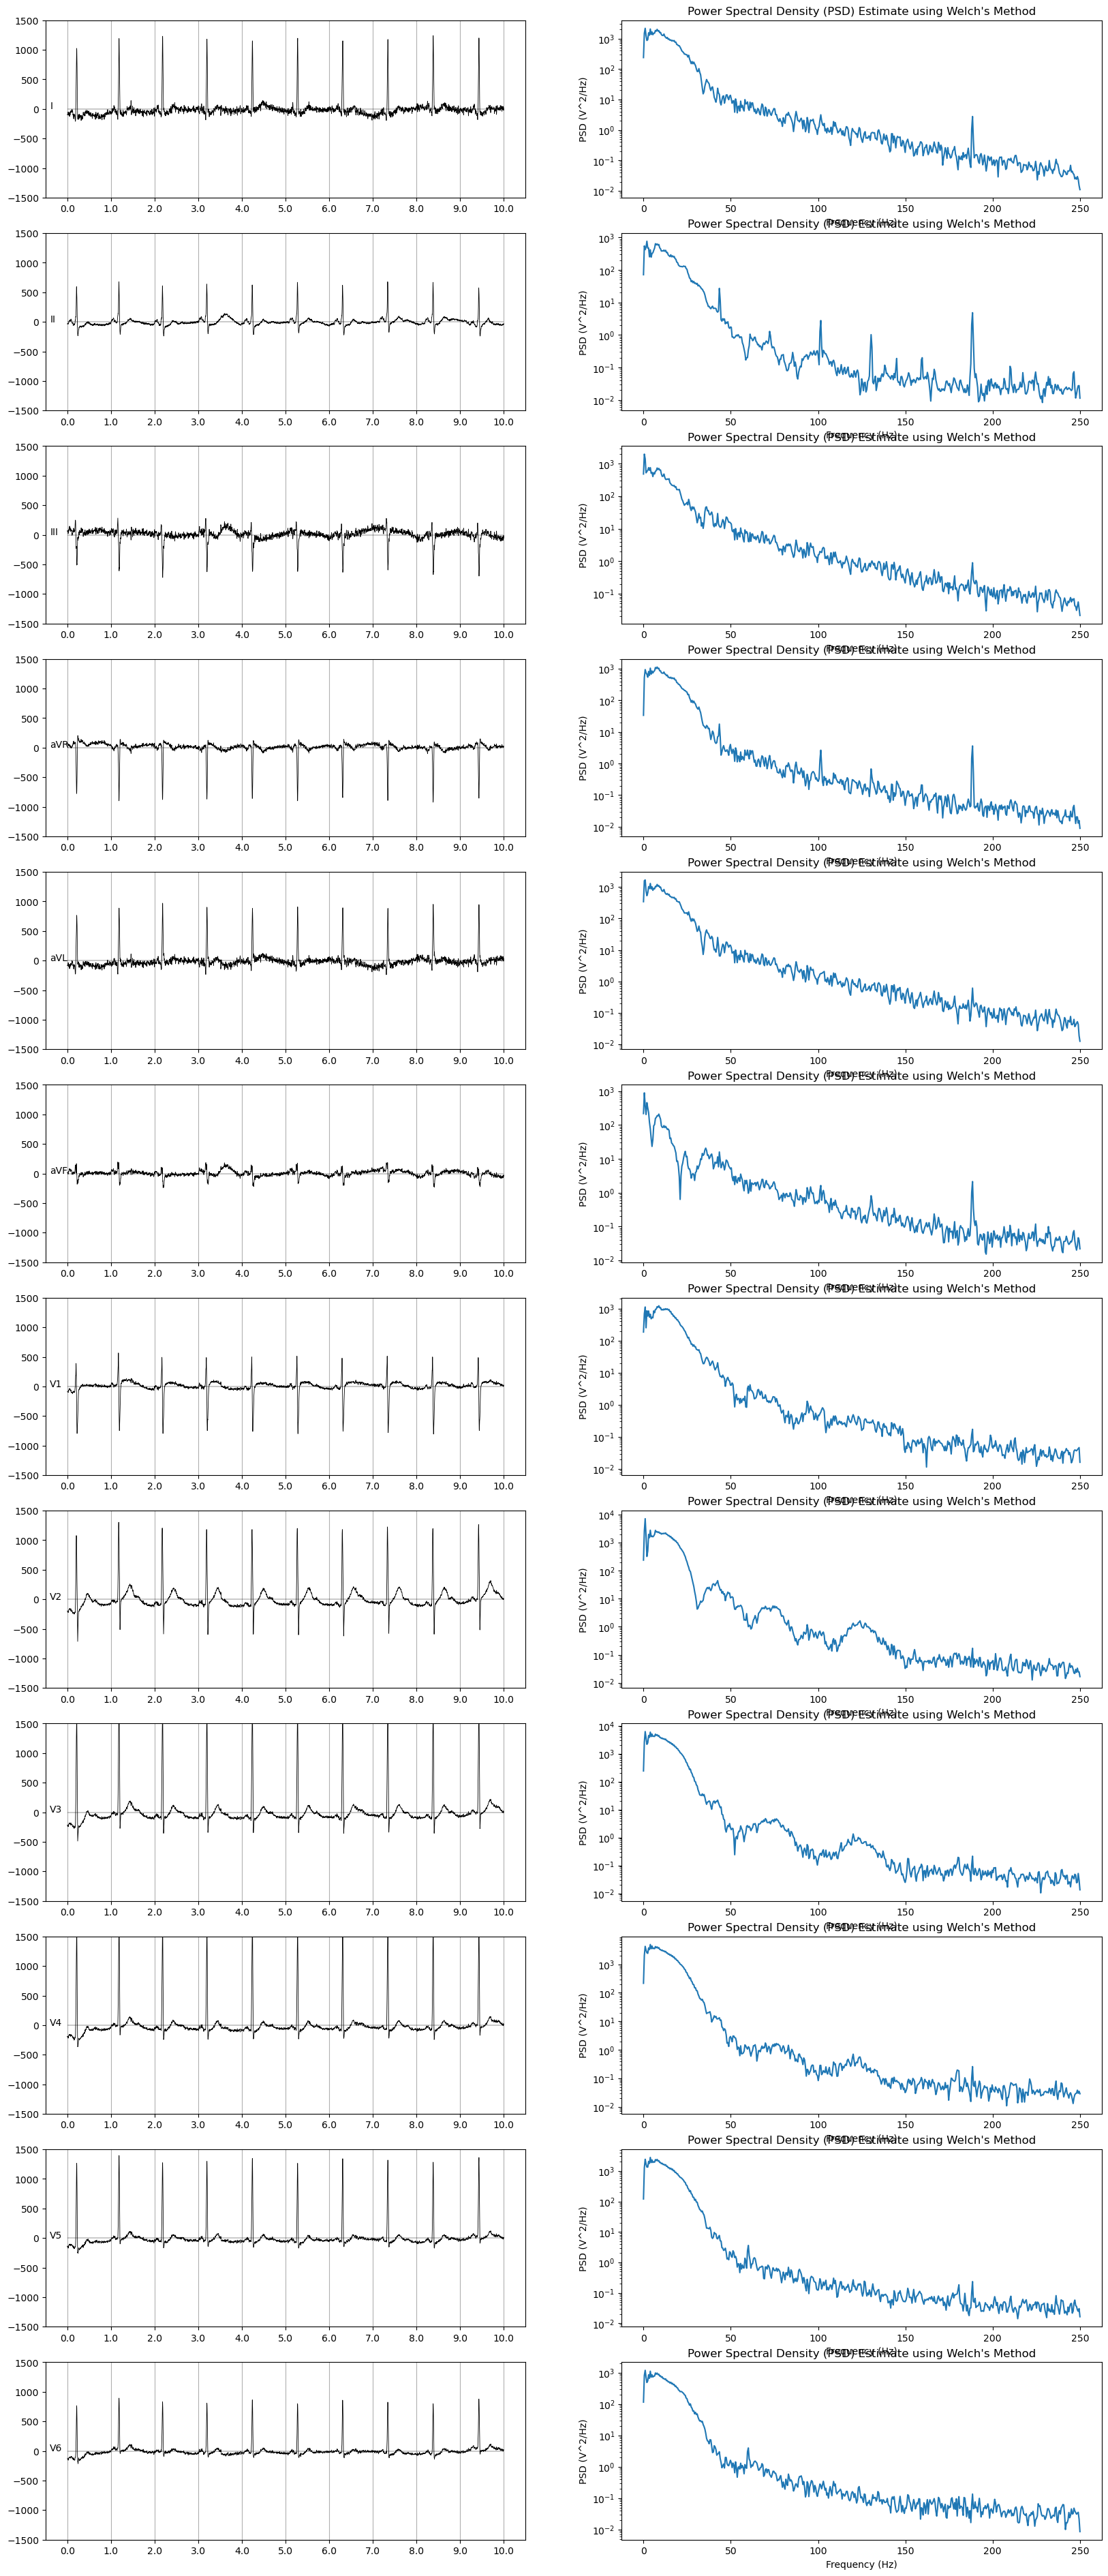

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

fig,ax = plt.subplots(12,2, figsize=(20,12*4))
#fig.set_dpi(150)
for i in range(0,12):
    _key = g_leads[i]
    #ax[i].set_title(_key)
    ax[i,0].plot(patient_signal[_key], color='black', linewidth=0.6)
    ax[i,0].set_ylim((-1500,1500))
    ax[i,0].set_xticks(   np.arange(0,5001,500)  )   
    ax[i,0].set_xticklabels(   np.arange(0,5001,500)/fs  )   
    ax[i,0].grid(axis='x')
    ax[i,0].annotate(_key,(-200,0))
    #ax[i].set_xlabel('Time(sec)')
    #ax[i].set_ylabel('mV')
    ax[i,0].hlines(0,0,5000,color='black', linewidth=0.3)

    frequencies, psd_values = welch(patient_signal[_key], fs, nperseg=1024)

    # Plotting the estimated PSD
    ax[i,1].semilogy(frequencies, psd_values)
    ax[i,1].set_title('Power Spectral Density (PSD) Estimate using Welch\'s Method')
    ax[i,1].set_xlabel('Frequency (Hz)')
    ax[i,1].set_ylabel('PSD (V^2/Hz)')



plt.show()

Welch periodogram example

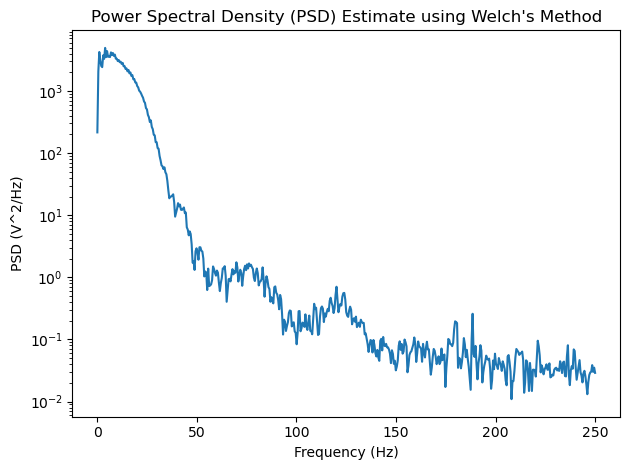

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Generate a noisy signal for demonstration
np.random.seed(42)  # Ensure reproducibility
fs = 500  # Sampling frequency in Hz
t = np.arange(0, 10, 1/fs)  # Time vector from 0 to 10 seconds
# Create a signal with two sine waves and random noise
signal = np.sin(2*np.pi*50*t) + 0.5*np.sin(2*np.pi*120*t) + np.random.normal(0, 2, t.shape)

# Apply Welch's method to estimate the PSD
frequencies, psd_values = welch(patient_signal['V4'], fs, nperseg=1024)

# Plotting the estimated PSD
plt.semilogy(frequencies, psd_values)
plt.title('Power Spectral Density (PSD) Estimate using Welch\'s Method')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.tight_layout()
plt.show()


Detrending

High pass filter

In [5]:
from scipy import signal
import scipy

def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='lowpass', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

# Design a Notch Filter to remove 60 Hz power line interference
def notch_filter(frequency, fs, quality_factor=30):
    b, a = signal.iirnotch(frequency, quality_factor, fs)
    return b, a

def apply_notch_filter(data, frequency, fs, quality_factor=30):
    b, a = notch_filter(frequency, fs, quality_factor)
    y = signal.filtfilt(b, a, data)
    return y


def scipy_notch_filter(data, fs, frequency, quality):
    return scipy.signal.filtfilt(*scipy.signal.iirnotch(frequency / (fs / 2), quality), data)


for patient in ecg_data.keys():
    filtered_signal = ecg_data[patient]['ecg_signals']#.apply(lambda x: signal.detrend(x))
    filtered_signal = filtered_signal.apply(lambda x: highpass_filter(data = x, cutoff=0.04, fs=fs))

    filtered_signal = filtered_signal.apply(lambda x: lowpass_filter(data = x, cutoff=140, fs=fs))
    filtered_signal = filtered_signal.apply(lambda x: scipy_notch_filter(data=x, frequency=50, fs=fs, quality=30))
    ecg_data[patient]['ecg_signals_filtered'] = filtered_signal



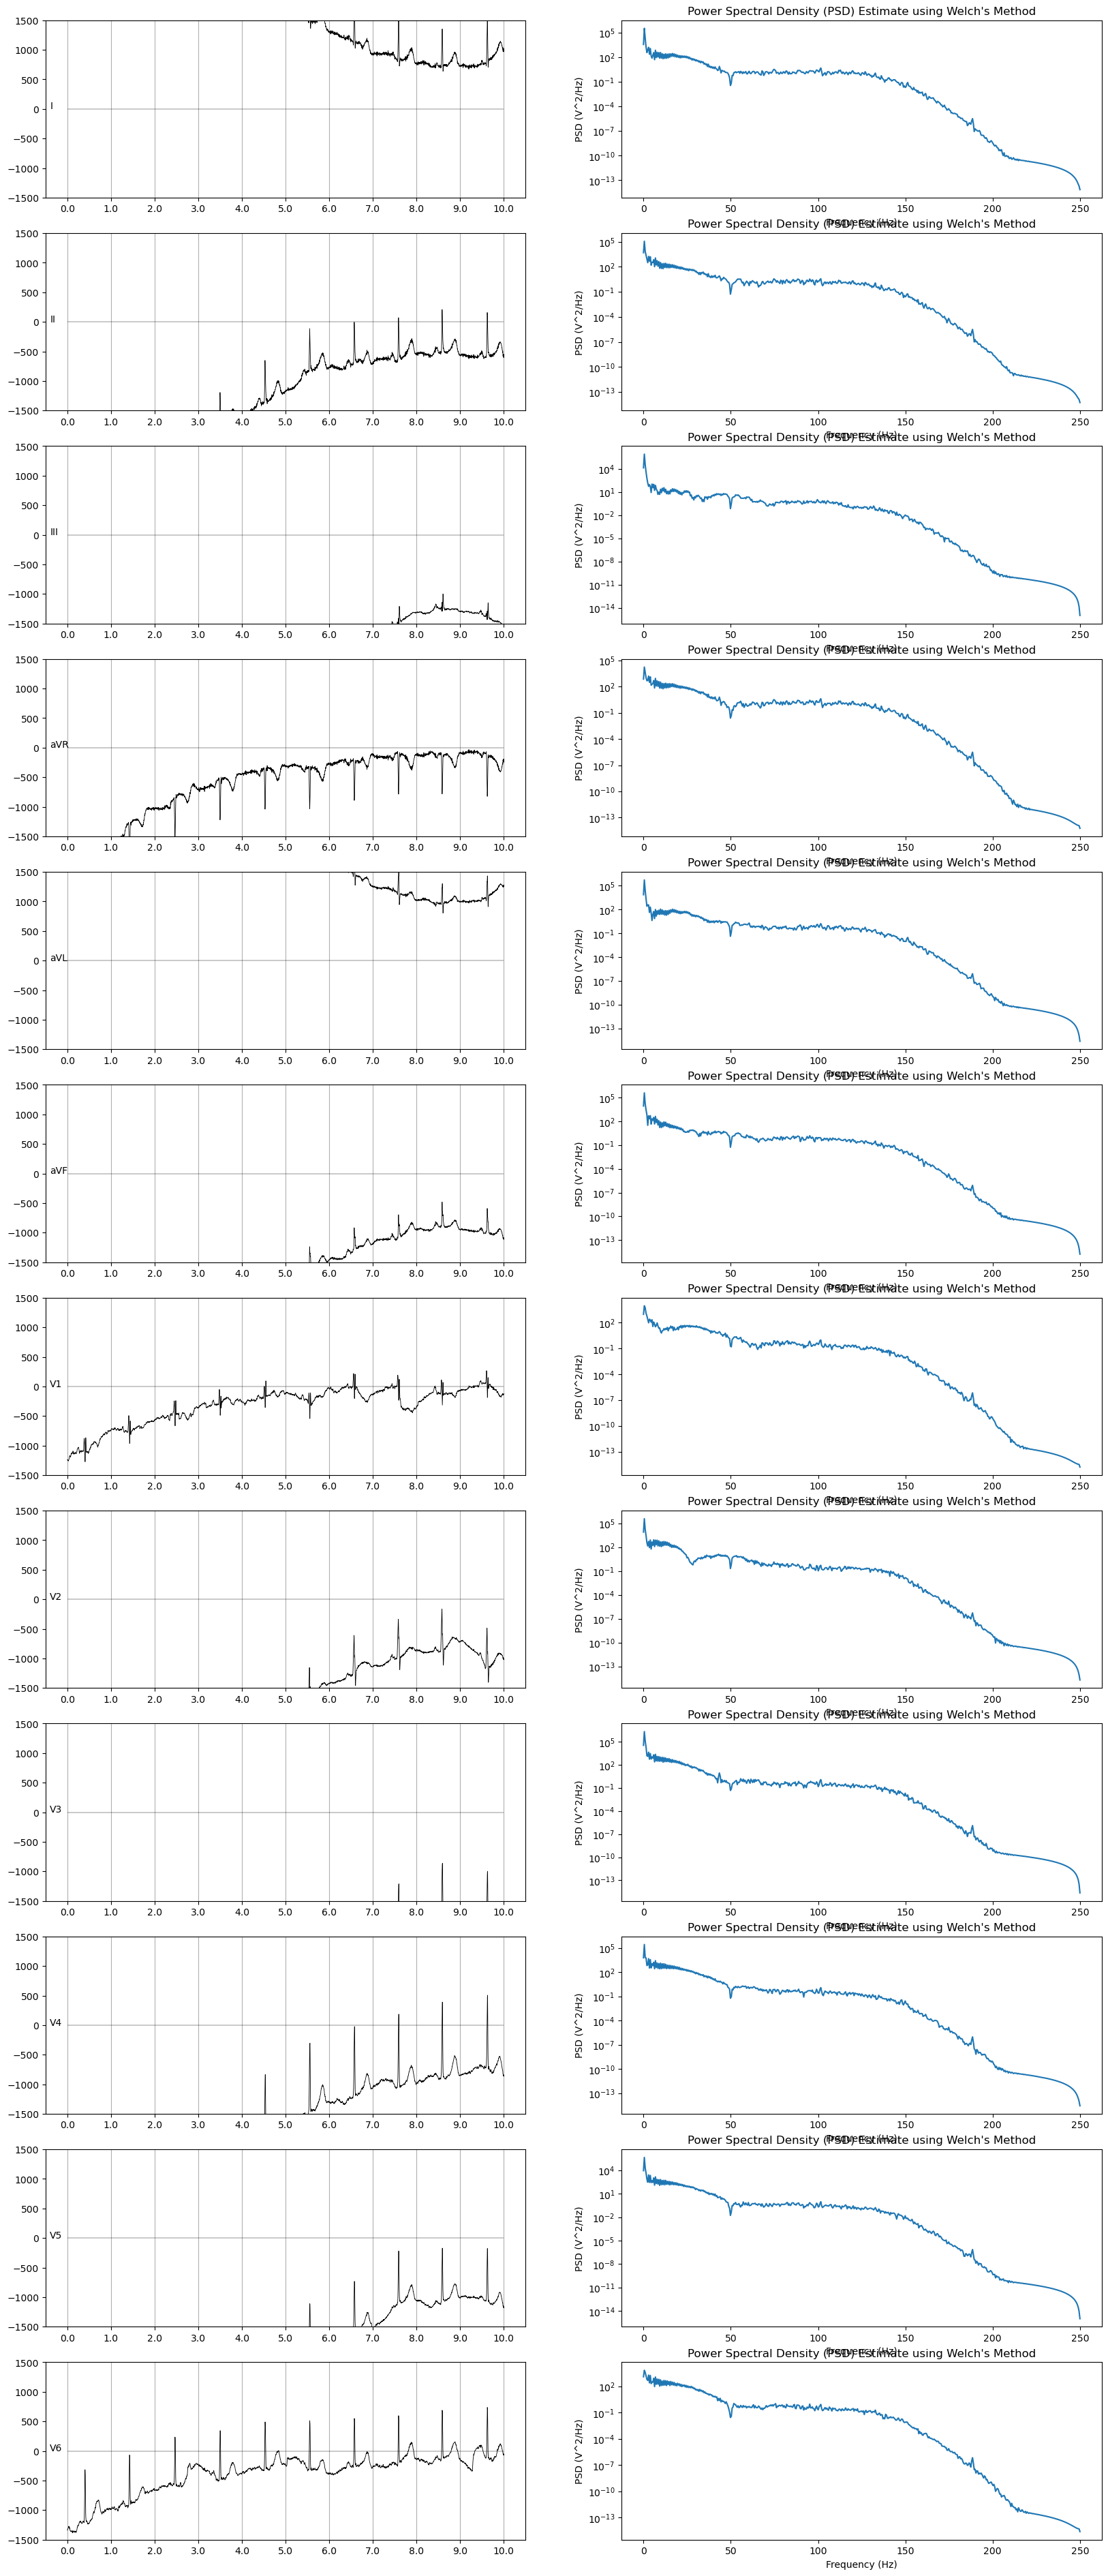

In [6]:
patient_signal_filtered = ecg_data[patient]['ecg_signals_filtered']

fig,ax = plt.subplots(12,2, figsize=(20,12*4))
#fig.set_dpi(150)
for i in range(0,12):
    _key = g_leads[i]
    #ax[i].set_title(_key)
    ax[i,0].plot(patient_signal_filtered[_key], color='black', linewidth=0.6)
    ax[i,0].set_ylim((-1500,1500))
    ax[i,0].set_xticks(   np.arange(0,5001,500)  )   
    ax[i,0].set_xticklabels(   np.arange(0,5001,500)/fs  )   
    ax[i,0].grid(axis='x')
    ax[i,0].annotate(_key,(-200,0))
    #ax[i].set_xlabel('Time(sec)')
    #ax[i].set_ylabel('mV')
    ax[i,0].hlines(0,0,5000,color='black', linewidth=0.3)
    
    frequencies, psd_values = welch(patient_signal_filtered[_key], fs, nperseg=1024)

    # Plotting the estimated PSD
    ax[i,1].semilogy(frequencies, psd_values)
    ax[i,1].set_title('Power Spectral Density (PSD) Estimate using Welch\'s Method')
    ax[i,1].set_xlabel('Frequency (Hz)')
    ax[i,1].set_ylabel('PSD (V^2/Hz)')



plt.show()

In [7]:
ecg_data

{'JS02314': {'ecg_signals':        I  II  III  aVR  aVL  aVF   V1   V2   V3   V4   V5   V6
  0     29 -59  -88   15   59  -73    0  -49  -78  195 -127 -166
  1     29 -59  -88   15   59  -73    0  -49  -78  195 -127 -166
  2     29 -59  -88   15   59  -73    0  -49  -78  195 -127 -166
  3     29 -59  -88   15   59  -73    0  -49  -78  195 -127 -166
  4     20 -68  -88   24   54  -78  -10  -49  -78  195 -132 -176
  ...   ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
  4995 -34  59   93  -10  -63   73 -102 -464 -508 -703 -605 -576
  4996 -34  59   93  -10  -63   73 -102 -464 -508 -708 -605 -576
  4997 -34  59   93  -10  -63   73 -102 -464 -512 -708 -605 -576
  4998 -15  68   83  -24  -49   73  -93 -464 -512 -708 -595 -566
  4999 -29  63   93  -15  -63   78 -102 -473 -522 -708 -610 -576
  
  [5000 rows x 12 columns],
  'diagnosis': '426177001',
  'metadata': {'age': '51', 'sex': 'Female'},
  'ecg_signals_filtered':                 I           II          III          aVR       

Features Extracted:

Average Heart Rate (bpm): The average heart rate over the entire ECG recording.
RR Intervals (s): The time intervals between successive R-peaks.
SDNN (s): The standard deviation of the RR intervals, a common HRV metric.
RMSSD (s): The root mean square of successive differences of RR intervals, a measure of HRV.
LF Power: Power in the low-frequency band (0.04–0.15 Hz), associated with sympathetic modulation.
HF Power: Power in the high-frequency band (0.15–0.4 Hz), associated with parasympathetic (vagal) activity.
LF/HF Ratio: The ratio of low-frequency to high-frequency power, often used as a measure of autonomic balance.
Average ST-Segment Deviation: The average deviation of the ST segment after each R-peak, which can be indicative of ischemic conditions.


In [41]:
import numpy as np
from scipy.signal import find_peaks, welch

# Helper functions from before
def detect_r_peaks_wfdb(ecg_signal, sampling_rate):
    r_peaks, _ = find_peaks(ecg_signal, distance=sampling_rate * 0.6)
    return r_peaks

def compute_rr_intervals_wfdb(r_peaks, sampling_rate):
    rr_intervals = np.diff(r_peaks) / sampling_rate
    return rr_intervals

def compute_heart_rate_wfdb(rr_intervals):
    hr = 60 / rr_intervals
    return hr

def compute_hrv_wfdb(rr_intervals):
    sdnn = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))
    return sdnn, rmssd

def compute_psd_wfdb(ecg_signal, sampling_rate, nperseg=256):
    freqs, psd = welch(ecg_signal, fs=sampling_rate, nperseg=nperseg)
    return freqs, psd

def extract_frequency_band_power_wfdb(freqs, psd, band):
    band_power = np.trapz(psd[(freqs >= band[0]) & (freqs <= band[1])], freqs[(freqs >= band[0]) & (freqs <= band[1])])
    return band_power

def compute_st_segment_deviation_wfdb(ecg_signal, r_peaks, sampling_rate):
    st_deviation = []
    for r_peak in r_peaks:
        st_start = int(r_peak + 0.08 * sampling_rate)
        st_end = int(st_start + 0.06 * sampling_rate)
        if st_end < len(ecg_signal):
            st_segment = ecg_signal[st_start:st_end]
            st_deviation.append(np.mean(st_segment))
    return st_deviation

# Main function to apply feature extraction on the dataset
def extract_features_from_ecg(data, sampling_rate):
    results = {}

    for patient_id, patient_data in data.items():
        ecg_signals = patient_data['ecg_signals']
        ecg_filtered_signals = patient_data['ecg_signals_filtered']
        disease = patient_data['diagnosis']

        # Extract features using Lead II for time-domain and frequency-domain features
        lead_ii = ecg_filtered_signals['II'].values
        
        # Detect R-peaks and compute RR intervals (Lead II)
        r_peaks = detect_r_peaks_wfdb(lead_ii, sampling_rate)
        rr_intervals = compute_rr_intervals_wfdb(r_peaks, sampling_rate)

        # Calculate Heart Rate and HRV (Lead II)
        heart_rate = compute_heart_rate_wfdb(rr_intervals)
        avg_heart_rate = np.mean(heart_rate)
        sdnn, rmssd = compute_hrv_wfdb(rr_intervals)

        # Frequency domain features (Lead II)
        freqs, psd = compute_psd_wfdb(lead_ii, sampling_rate)
        lf_power = extract_frequency_band_power_wfdb(freqs, psd, band=(0.04, 0.15))
        hf_power = extract_frequency_band_power_wfdb(freqs, psd, band=(0.15, 0.4))
        lf_hf_ratio = lf_power / hf_power if hf_power != 0 else np.inf

        # ST-segment deviation for all leads
        st_deviations = {}
        for lead in ecg_filtered_signals.columns:
            st_deviations[lead] = compute_st_segment_deviation_wfdb(ecg_filtered_signals[lead].values, r_peaks, sampling_rate)

        avg_st_deviations = {f"Avg_ST_D_{lead}": np.mean(deviation) for lead, deviation in st_deviations.items() if len(deviation) > 0}

        # Collect results
        results[patient_id] = {
            "Average Heart Rate (bpm)": avg_heart_rate,
            # "RR Intervals (s)": rr_intervals,
            "SDNN (s)": sdnn,
            "RMSSD (s)": rmssd,
            # "LF Power": lf_power,
            # "HF Power": hf_power,
            # "LF/HF Ratio": lf_hf_ratio,
            "Diagnosis": disease
        }

        results[patient_id].update(avg_st_deviations)
    return results


# Assume a sampling rate of 500Hz (adjust according to actual data)
results = extract_features_from_ecg(ecg_data, fs)
features_df = pd.DataFrame.from_dict(results, orient='index')
print(features_df)



         Average Heart Rate (bpm)  SDNN (s)  RMSSD (s)            Diagnosis  \
JS02314                 74.140873  0.194930   0.127425            426177001   
JS02300                 77.372225  0.174040   0.180647            426177001   
JS02328                 67.596297  0.003497   0.004648            427084000   
JS02329                 73.962761  0.213736   0.174845            427084000   
JS02301                 75.841002  0.186153   0.304977  164889003,164934002   
...                           ...       ...        ...                  ...   
JS02324                 83.145340  0.172261   0.159215            427084000   
JS02325                 75.660888  0.264349   0.249175            426177001   
JS02331                 82.777183  0.007869   0.012083            426783006   
JS02319                 67.952453  0.170581   0.165218            426177001   
JS02292                 66.652138  0.167920   0.148041  426177001,251146004   

           Avg_ST_D_I   Avg_ST_D_II  Avg_ST_D_III  

In [42]:
diseases = pd.read_csv("/Users/marcpalomercadenas/Desktop/ML/ECG_prediction/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/ConditionNames_SNOMED-CT.csv")
diseases=diseases.rename(columns={"Snomed_CT": "Disease"})

In [43]:
#Librerías:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MultiLabelBinarizer

y = features_df['Diagnosis'].apply(lambda x: x.split(','))
X = features_df.loc[:,features_df.columns != 'Diagnosis'] 

mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(y)

label_df = pd.DataFrame(binary_labels, columns=mlb.classes_)
label_df.head()




#Dividimos los conjuntos de entrenamiento(70%) y test(30). 
X_train, X_test, y_train, y_test = train_test_split(X, label_df, test_size=0.3, random_state=42)
# mlb.classes_

In [44]:
X_train

Average Heart Rate (bpm)  SDNN (s)  RMSSD (s)   Avg_ST_D_I  \
JS02306                 80.870670  0.128658   0.145287  -296.175068   
JS02342                 73.890613  0.191970   0.134720 -8079.766015   
JS02337                 67.147259  0.148783   0.196606  2460.726932   
JS02360                 79.638404  0.031095   0.047681  4582.353033   
JS02293                 90.582054  0.011172   0.011675 -2078.809944   
...                           ...       ...        ...          ...   
JS02387                 83.140356  0.188528   0.175569 -3855.290195   
JS02353                 70.045773  0.173982   0.205398  1492.853691   
JS02307                 65.664227  0.152737   0.132948 -2350.551670   
JS02291                 75.725159  0.236805   0.174323 -1517.148198   
JS02394                 56.808507  0.016621   0.024576 -1808.785928   

         Avg_ST_D_II  Avg_ST_D_III  Avg_ST_D_aVR  Avg_ST_D_aVL  Avg_ST_D_aVF  \
JS02306 -6398.707955  -5884.426823   3256.926884   2876.062789  -6230.012165   
JS02342 -6146.325187   2010.019167   6961.482185  -5126.273823  -2090.720760   
JS02337  -969.873597  -3417.289325   -668.971668   2888.625904  -2171.169864   
JS02360  3922.684111   -612.936526  -4347.817656   2549.939291   1689.457493   
JS02293 -1515.577064    628.233055   1837.427846  -1439.491483   -332.716088   
...              ...           ...           ...           ...           ...   
JS02387 -2424.100271   1430.908467   3133.579776  -2564.903332   -604.403821   
JS02353  1445.768148   -112.097938  -1420.560917    791.600004    683.591773   
JS02307  -825.183958   1606.587566   1818.398568  -2002.957321    201.296561   
JS02291 -6586.738754  -5149.952745   3945.543923   1770.484657  -5913.522951   
JS02394 -1942.088239    -89.581883   1997.924518   -800.304499  -1085.495958   

          Avg_ST_D_V1   Avg_ST_D_V2   Avg_ST_D_V3  Avg_ST_D_V4   Avg_ST_D_V5  \
JS02306  -3818.174707    827.824657    807.256723 -2043.367542  -3392.029812   
JS02342   -709.050930    812.712643   1493.922239  -848.581773  -3875.913753   
JS02337  13335.438204  30738.296046  15685.728584  7073.711420   4545.427277   
JS02360  -2688.030852   4144.091858   6219.085932  -125.341767   3892.529251   
JS02293    979.632280   2541.095151   1235.860500  -177.312914   -904.722658   
...               ...           ...           ...          ...           ...   
JS02387 -11053.794794 -12300.619190 -11189.339051  7985.039671  -5654.026203   
JS02353   -713.767575  -5987.957121  -1124.345444  1885.299033  16102.328056   
JS02307  -1388.069757  -2794.359028   -417.412970  -524.220994    118.756983   
JS02291   -976.138190  -2182.129761  -3603.660636 -3305.080788  -2543.018647   
JS02394   1392.855111  -1210.406745  -2307.992420 -2543.272415  -1629.615466   

         Avg_ST_D_V6  
JS02306 -4786.548061  
JS02342 -1098.918214  
JS02337  1154.349833  
JS02360  6058.476731  
JS02293 -1155.869398  
...              ...  
JS02387 -4522.791959  
JS02353 -2332.596322  
JS02307  -160.361996  
JS02291 -2614.804447  
JS02394 -2514.085810  

[70 rows x 15 columns]

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Create a multi-label RandomForestClassifier
model = RandomForestClassifier()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
Y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, Y_pred)
f1 = f1_score(y_test, Y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")


Accuracy: 0.13333333333333333
F1 Score: 0.17550565376652333


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [18]:


#Modelos de clasificación
models = dict([("Random Forest", RandomForestClassifier()), 
          ('Logistic Regression', LogisticRegression(max_iter=10000)), 
          ('Support Vector Machine', SVC()),
          ('XGBoost', XGBClassifier()),
          ('LightGBM', LGBMClassifier())])

# Evaluar los modelos utilizando validación cruzada
for name, model in models.items():
    print(f'{name}:')
    # Volidación cruzada
    scores = cross_val_score(model, X_train, y_train, cv=7, scoring = 'balanced_accuracy')
    print(f'Mean cross-validation score: {scores.mean():.3f}')
    print(f'Standard deviation: {scores.std():.3f}')
  
    #Ajuste con train:
    model.fit(X_train, y_train)
    
    #Predicción con test:
    y_pred = model.predict(X_test)
    
    #Resultados
    accuracy = accuracy_score(y_test, y_pred)#Exactitud
    precision = precision_score(y_test, y_pred, average='weighted')#Precisión
    recall = recall_score(y_test, y_pred, average='weighted')
    
    print(f'Accuracy score on test data: {accuracy:.3f}')
    print(f'Precision score on test data: {precision:.3f}')
    print(f'Recall score on test data: {recall:.3f}\n')

#REPETIMOS CON LOS DATOS NORMALIZADOS:
print(' ')
print('With scaled data')
print(' ')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
normalizer = Normalizer().fit(X)
X_train_scaled=normalizer.transform(X_train_scaled)
X_test_scaled=normalizer.transform(X_test_scaled)

#Utilizamos los mismos modelos:
models = dict([("Random Forest", RandomForestClassifier()), 
          ('Logistic Regression', LogisticRegression(max_iter=10000)), 
          ('Support Vector Machine', SVC()),
          ('XGBoost', XGBClassifier()),
          ('LightGBM', LGBMClassifier())])

# Evaluar los modelos utilizando validación cruzada
for name, model in models.items():
    print(f'{name}:')
    
    # Validación cruzada
    scores = cross_val_score(model, X_train_scaled, y_train, cv=7, scoring='balanced_accuracy')
    print(f'Mean cross-validation score: {scores.mean():.3f}')
    print(f'Standard deviation: {scores.std():.3f}')
    
    model.fit(X_train_scaled, y_train) #Ajuste del modelo a los datos de entrenamiento escalados y las etiquetas. 
    
    #Predicción con los datos test escalados:
    y_pred = model.predict(X_test_scaled)
    
    #Resultados:
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Accuracy score on test data: {accuracy:.3f}')
    print(f'Precision score on test data: {precision:.3f}')
    print(f'Recall score on test data: {recall:.3f}\n')

#print(X)a


Random Forest:
Mean cross-validation score: nan
Standard deviation: nan


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
7 fits failed out of a total of 7.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 327, in fit
    X, y = self._vali

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').